

# Project: Comparison of Existing Algorithms applied on Flappy Bird

<a href="https://github.com/lplacidet/evolution_project">https://github.com/lplacidet/evolution_project</a>

Importing Libraries

In [1]:
using Random
using LinearAlgebra
using Statistics
using Plots

using Cxx, Libdl

gr(reuse=true)

Plots.GRBackend()

In [2]:
const path_to_lib = pwd()
addHeaderDir(path_to_lib*"/world/", kind=C_System)
cxxinclude("runWorld.h")
print("gg")
#objective = @cxx FlappyXP->evaluate
print("re-gg")

ggre-gg

In [3]:
N_genes = 5

mutable struct Individu
    genes::Array{Float64}
    fitness::Float64
end

function Individu(n::Int)
    newgenes = zeros(n)
    for i in 1:n
        newgenes[i] = rand()
    end
    Individu(newgenes, -Inf)
end 

Individu(N_genes)

Individu([0.20102182381846512, 0.2355178671314755, 0.7961666800629108, 0.4810663422452288, 0.451564760508788], -Inf)

In [4]:
cxx"""

static double evaluate_bird(float g1, float g2, float g3, float g4, float g5) {
float ind[5] = {g1,g2,g3,g4,g5};
bool dbg = false;
#ifdef DISPLAY
	initscr();
	timeout(0);
	noecho();
	curs_set(FALSE);
#endif
	const int NRUN = 3;
	auto &g = ind;
	double d = 0;
	for (int r = 0; r < NRUN; ++r) {
		World world;
		world.gen.seed(r * 100);
		while (world.bestiau.vivant) {
#ifdef DISPLAY
            std::this_thread::sleep_for(std::chrono::milliseconds(25));
            display(world, world.dist == 0);
#endif
            world.update();
            // update inputs
            float birdY = world.bestiau.y;
            float birdVY = world.bestiau.vit;
            float obsX;
            float obsY;
            if (world.obstacles.size() > 0) {
                const auto &o = world.obstacles.front();
                obsY = o.y + world.hauteurPassage * 0.5;
                obsX = o.x / world.W;
            } else {
                obsY = world.H * 0.5;
                obsX = 1000.0;
            }
            if ((g[0]*birdY+g[1]*birdVY+g[2]*obsX+g[3]*obsY+g[4]*world.dist)>1.0) world.bestiauUp();
        }
        d += world.dist;
        float distToTunnel = world.bestiau.y-(world.obstacles.front().y+world.hauteurPassage*0.5);
        d += 0.3*(1-((distToTunnel*distToTunnel)/(world.H*world.H)));
    }
#ifdef DISPLAY
    endwin();
#endif
    return d;
}
"""

true

In [5]:
cxx"""
#define DISPLAY
#include <chrono>
#include "coverage.hpp"
#include "include/gaga/gaga.hpp"
#include "include/grgen/multiint.hpp"
#include "include/grgen/real.hpp"
#include "include/grgen/grn.hpp"
#include "signalxp.hpp"
#include "bestiau.hpp"
#include <curses.h>

static double evaluate_bird_display(float g1, float g2, float g3, float g4, float g5) {
float ind[5] = {g1,g2,g3,g4,g5};
bool dbg = false;
#ifdef DISPLAY
	initscr();
	timeout(0);
	noecho();
	curs_set(FALSE);
#endif
	const int NRUN = 3;
	auto &g = ind;
	double d = 0;
	for (int r = 0; r < NRUN; ++r) {
		World world;
		world.gen.seed(r * 100);
		while (world.bestiau.vivant) {
#ifdef DISPLAY
            std::this_thread::sleep_for(std::chrono::milliseconds(25));
            display(world, world.dist == 0);
#endif
            world.update();
            // update inputs
            float birdY = world.bestiau.y;
            float birdVY = world.bestiau.vit;
            float obsX;
            float obsY;
            if (world.obstacles.size() > 0) {
                const auto &o = world.obstacles.front();
                obsY = o.y + world.hauteurPassage * 0.5;
                obsX = o.x / world.W;
            } else {
                obsY = world.H * 0.5;
                obsX = 1000.0;
            }
            if ((g[0]*birdY+g[1]*birdVY+g[2]*obsX+g[3]*obsY+g[4]*world.dist)>1.0) world.bestiauUp();
        }
        d += world.dist;
        float distToTunnel = world.bestiau.y-(world.obstacles.front().y+world.hauteurPassage*0.5);
        d += 0.3*(1-((distToTunnel*distToTunnel)/(world.H*world.H)));
    }
#ifdef DISPLAY
    endwin();
#endif
    return d;
}
"""

In file included from /Cxx.cpp:1:
In[5]:30:13: error: use of undeclared identifier 'display'
            display(world, world.dist == 0);
            ^


true

In [6]:
cpptojulia(g1::Float64, g2::Float64, g3::Float64, g4::Float64, g5::Float64) = @cxx evaluate_bird(g1,g2,g3,g4,g5)

cpptojulia (generic function with 1 method)

In [7]:
function evaluate_bird(g::Array{Float64})
    -1*cpptojulia(g[1],g[2],g[3],g[4],g[5])
end

evaluate_bird (generic function with 1 method)

In [8]:
test_ind = Individu(N_genes)
println(test_ind)
cpptojulia(test_ind.genes[1], test_ind.genes[2],test_ind.genes[3], test_ind.genes[4], test_ind.genes[5])

Individu([0.9011397122391518, 0.25614221709048923, 0.16486898583893628, 0.12364170879013758, 0.7637354439918853], -Inf)


1.8873729519689084



## I. CMA-ES Algorithm


In [9]:
mutable struct CMAES
    N::Int
    μ::Int
    λ::Int
    τ::Float64
    τ_c::Float64
    τ_σ::Float64
    population::Array{Array{Float64}}
    offspring::Array{Array{Float64}}
    F_μ::Array{Float64}
    F_λ::Array{Float64}
    C::Array{Float64}
    s::Array{Float64}
    s_σ::Array{Float64}
    σ::Float64
    E::Array{Float64}
    W::Array{Float64}
    x::Array{Float64}
end

In [10]:
N_value = N_genes
mu = 5
lambda = 5
objective = evaluate_bird

evaluate_bird (generic function with 1 method)

In [11]:
function CMAES(;N=N_value, μ=mu, λ=lambda, τ=sqrt(N), τ_c=N^2, τ_σ=sqrt(N))
    x = randn(N)
    population = fill(x, µ)
    offspring = Array{Array{Float64}}(undef, λ)
    F_µ = Inf .* ones(µ)
    F_λ = Inf .* ones(λ)
    C = Array(Diagonal{Float64}(I, N))
    s = zeros(N)
    s_σ = zeros(N)
    σ = 0.1
    E = zeros(N, λ)
    W = zeros(N, λ);
    CMAES(N, μ, λ, τ, τ_c, τ_σ, population, offspring, F_µ, F_λ, C, s, s_σ, σ, E, W, x)
end

CMAES

In [12]:
function step_cmaes!(c::CMAES; obj=objective, visualize=false, anim=Nothing)
    # L1
    sqrt_c = cholesky((c.C + c.C') / 2.0).U
    for i in 1:c.λ
        c.E[:,i] = randn(c.N)
        c.W[:,i] = c.σ * (sqrt_c * c.E[:,i])
        c.offspring[i] = c.x + c.W[:,i]
        c.F_λ[i] =  obj(c.offspring[i])
    end    
    # Select new parent population
    idx = sortperm(c.F_λ)[1:c.μ]
    for i in 1:c.μ
        c.population[i] = c.offspring[idx[i]]
        c.F_μ[i] = c.F_λ[idx[i]]
    end    
    # L2
    w = vec(mean(c.W[:,idx], dims=2))
    c.x += w 
    # L3
    c.s = (1.0 - 1.0/c.τ)*c.s + (sqrt(c.μ/c.τ * (2.0 - 1.0/c.τ))/c.σ)*w   
    # L4
    c.C = (1.0 - 1.0/c.τ_c).*c.C + (c.s./c.τ_c)*c.s'    
    # L5
    ɛ = vec(mean(c.E[:,idx], dims=2))
    c.s_σ = (1.0 - 1.0/c.τ_σ)*c.s_σ + sqrt(c.μ/c.τ_σ*(2.0 - 1.0/c.τ_σ))*ɛ    
    # L6
    c.σ = c.σ*exp(((c.s_σ'*c.s_σ)[1] - c.N)/(2*c.N*sqrt(c.N)))
    #println("this is old sigma ---> ",c.σ)
    if c.σ > 1.0
        c.σ = 1.0
        print(" -cs") #stands for "capping sigma"
    end
    #println("this is new sigma ---> ",c.σ)
    if visualize
        plot(xs, ys, fz, st=:contour)
        scatter!([c.offspring[i][1] for i in 1:λ], [c.offspring[i][2] for i in 1:λ], 
            xlims=(-5, 5), ylims=(-5, 5), legend=:none)
        scatter!([c.x[1]], [c.x[2]], color=:black, marker=:rect,
            xlims=(-5, 5), ylims=(-5, 5), legend=:none)
        frame(anim)
    end
    c
end

step_cmaes! (generic function with 1 method)

In [13]:
function plot_obj_cmaes()
    c = CMAES()
    println("x initial: ", c.x)
    anim = Animation()
    for i in 1:100
        v = mod(i, 1) == 0
        step_cmaes!(c, visualize=v, anim=anim)
    end
    println("x final: ", c.x)
    gif(anim)
end

plot_obj_cmaes (generic function with 1 method)

In [14]:
function not_plot_obj_cmaes(nbgen::Int)
    freq = 1 #frequence d'echantillonage du graphique
    freq_purcent = 5 #afficher complétion tous les n%
    c = CMAES()
    gen = zeros(Int(nbgen/freq))
    fitness = zeros(Int(nbgen/freq))
    next_purcentage = freq_purcent
    for i in 1:nbgen
        v = mod(i, 1) == 0
        if i%freq==0
            gen[Int(i/freq)] = i
            fitness[Int(i/freq)] = -1*evaluate_bird(c.population[1])
        end
        step_cmaes!(c, visualize=false)
        if i/nbgen >= next_purcentage/100
            println(next_purcentage,"% done ...", c.σ)
            next_purcentage += freq_purcent
        end
    end
    c.population[1], gen, fitness
end

not_plot_obj_cmaes (generic function with 1 method)

 -cs5% done ...0.29780080414867516
10% done ...0.35429433577369185
 -cs -cs -cs -cs15% done ...0.735011038326642
 -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs20% done ...0.3394978062341515
25% done ...0.2983453933673009
30% done ...0.18961622832792852
35% done ...0.23965386046847736
40% done ...0.7087097152114107
 -cs -cs -cs -cs -cs -cs -cs45% done ...0.5407192066646008
 -cs -cs -cs -cs -cs50% done ...0.6492633809823871
 -cs55% done ...0.15037112050066503
60% done ...0.3772974549910002
 -cs -cs65% done ...0.7419024253425144
 -cs -cs -cs -cs -cs -cs -cs -cs70% done ...1.0
 -cs -cs -cs -cs -cs -cs75% done ...0.42381724902691503
 -cs80% done ...1.0
85% done ...0.14709336265322315
 -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs90% done ...1.0
 -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs -cs95% done ...0.6451899495222636
 -cs -cs -cs -cs -cs100% done ...0.6066389603070567
0.7698380868673325
[21.23768340017786, 5.794343610952084, 2.257589810254531

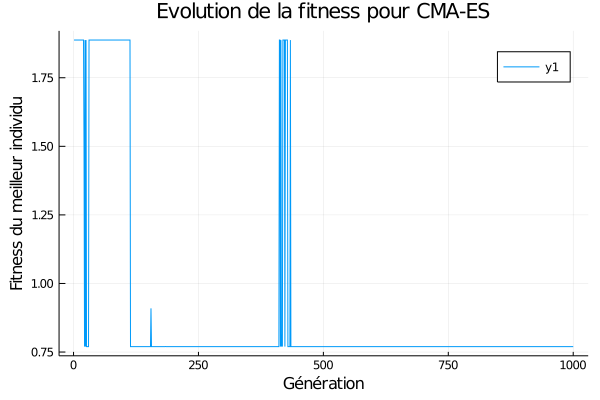

In [15]:
fz(x, y) = objective([x, y])
my_guess, liste_generations, liste_fitness = not_plot_obj_cmaes(1000)

println(-1*evaluate_bird(my_guess))
println(my_guess)

plot(liste_generations, liste_fitness, title = "Evolution de la fitness pour CMA-ES")
xlabel!("Génération")
ylabel!("Fitness du meilleur individu")



## II. ES (mu/signam, lambda)


In [16]:
npop = 50     # population size
sigma = 0.1   # noise standard deviation
alpha = 0.001 # step size
x = randn(2)  # initial expert

2-element Array{Float64,1}:
  3.237780058502901
 -0.339561512484326

In [17]:
xs = -5.0:0.1:5.0
ys = -5.0:0.1:5.0
#fz(x, y) = objective([x, y]);

function step_es(x::Array{Float64}; npop=50, sigma=0.1, alpha=0.01, visualize=false, anim=Nothing)
    N = randn(npop, 2)
    P = repeat(x, 1, npop)' .+ sigma .* N
    R = zeros(npop)
    for i in eachindex(R)
        R[i] = objective(P[i, :]) #evaluation
    end
    A = (R .- mean(R)) ./ std(R) #the selection is done here: we are giving a higher porbability to individuals that did well
    
    if visualize
        plot(xs, ys, fz, st=:contour)
        scatter!(P[:, 1], P[:, 2], xlims=(-5, 5), ylims=(-5, 5), zcolor=R)
        scatter!([x[1]], [x[2]], legend=:none, color=:black, marker=:rect)
        frame(anim)
    end
    
    x .+ alpha/(npop * sigma) .* [dot(N[:, i], A) for i in 1:size(N, 2)] #modification step: changing the center of gravity
end

step_es (generic function with 1 method)

In [18]:
function plot_obj_es()
    x = randn(2) #initial population: which is a single point
    println("x initial: ", x)
    anim = Animation()
    for i in 1:500
        v = mod(i, 10) == 0
        x = step_es(x, npop=50, sigma=0.1, alpha=0.001, visualize=v, anim=anim)
    end
    println("x final: ", x)
    gif(anim)
end

plot_obj_es (generic function with 1 method)

In [19]:
xs = -5.0:0.1:5.0
ys = -5.0:0.1:5.0

#fz(x, y) = objective_es([x, y])
println(solution) # optimal for sphere and rastrigin
#plot_obj_cmaes()

UndefVarError: UndefVarError: solution not defined